In [29]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

Downloading S&P500 Data

In [30]:
#Reading a list of stocks from internet:
sp = pd.read_html("https://es.wikipedia.org/wiki/Anexo:Compa%C3%B1%C3%ADas_del_S%26P_500")[0]
sp['Símbolo'] = sp['Símbolo'].str.replace('.','-')
symbols_list = sp['Símbolo'].unique().tolist()

# Drop some stocks that return error:
symbols_drop = ['PKI', 'ABC', 'FISV', 'SIVB', 'RE', 'FRC', 'ATVI']
[symbols_list.remove(x) for x in symbols_drop]

#Our time gap:
end_date = pd.to_datetime('today').normalize()
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*20)

#Request stocks info:
df = yf.download(tickers = symbols_list,
                 start = start_date,
                 end = end_date
                 )

rawdata10years = df.copy().stack()

[*********************100%%**********************]  496 of 496 completed


In [31]:
# Cambiamos los nombres de los indices:
rawdata10years.index.names = ['date', 'name']
# We have some issues with the multiIndex, so we recreate it.
rawdata10years.index = pd.MultiIndex.from_arrays([pd.to_datetime(rawdata10years.index.get_level_values(level=0)), rawdata10years.index.get_level_values(level=1)], names=['date','name'])
rawdata10years.columns = rawdata10years.columns.str.lower()
#Create a dollarvolume column for each stock, calculate de mean for the period, and rank stocks by volume.
rawdata10years['dollarvolume'] = (rawdata10years['adj close']*rawdata10years['volume'])/1e6
rawdata10years['dolvolmean'] = (rawdata10years['dollarvolume'].unstack('name').rolling(len(rawdata10years.unstack('name').index)).mean().stack('name'))
rawdata10years['dollarvolumerank'] = (rawdata10years.groupby('date')['dolvolmean'].rank(ascending=False))

In first place we are filtering the most liquid stocks.

In [32]:
#We are gonna get the 150 most liquid stocks in mean. 
mostliquid = rawdata10years[rawdata10years['dollarvolumerank']<=150]
liqstocks = []
for i in mostliquid.index:
    liqstocks.append(i[1])
    
# Redownload data:
df = yf.download(tickers = liqstocks,
                 start = start_date,
                 end = end_date
                 )

data = df.copy().stack()
# Cambiamos los nombres de los indices:
data.index.names = ['date', 'name']
# We have some issues with the multiIndex, so we recreate it.
data.index = pd.MultiIndex.from_arrays([pd.to_datetime(data.index.get_level_values(level=0)), data.index.get_level_values(level=1)], names=['date','name'])
data.columns = data.columns.str.lower()

[*********************100%%**********************]  150 of 150 completed


Indicators

Garman-Klass Volatility

In [33]:
data['gkvolatility'] = ((np.log(data['high'])-np.log(data['low']))**2)/2-(2*np.log(2)-1)*(np.log(data['adj close'])-np.log(data['open']))**2
data.head()

adj close      close       high        low       open  \
date       name                                                          
2003-12-31 AAPL   0.323481   0.381607   0.384464   0.378214   0.381250   
           ABT   13.094327  20.918781  21.008560  20.833490  20.963671   
           ACN   18.959490  26.320000  26.350000  26.000000  26.350000   
           ADBE  19.508415  19.540001  19.950001  19.459999  19.924999   
           ADI   28.948486  45.650002  45.900002  44.830002  45.459999   

                    volume  gkvolatility  
date       name                           
2003-12-31 AAPL  174451200     -0.010296  
           ABT     7922016     -0.085520  
           ACN     1471500     -0.041765  
           ADBE    4328400      0.000137  
           ADI     2378400     -0.078404

RSI

In [34]:
data['rsi'] = data.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
data.tail()

adj close       close        high         low        open  \
date       name                                                               
2023-12-22 WFC    49.180000   49.180000   49.860001   49.090000   49.660000   
           WMT   156.649994  156.649994  157.149994  155.160004  155.449997   
           WYNN   90.419998   90.419998   91.129997   89.910004   90.000000   
           XOM   101.910004  101.910004  102.940002  101.820000  102.309998   
           YUM   130.000000  130.000000  130.500000  129.410004  129.899994   

                   volume  gkvolatility        rsi  
date       name                                     
2023-12-22 WFC   10448000      0.000085  69.479421  
           WMT    6467400      0.000058  50.562973  
           WYNN   1170500      0.000082  54.535857  
           XOM   12921800      0.000054  47.162070  
           YUM     991500      0.000035  58.269030

Bollinger Bands

In [35]:
data['bblow'] = data.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
data['bbmid'] = data.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
data['bbtop'] = data.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

Average True Range (ATR)
The average true range (ATR) is a price volatility indicator showing the average price variation of assets within a given time period. Investors can use the indicator to determine the best time for trading. The average true range also takes into account the gaps in the movement of price.

In [36]:
# Definimos una funcion para extraer para cada accion su precio maximo diario, el minimo, su cierre, y con ello calcular el atr para cada una.
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length=14
                        )
    return atr.sub(atr.mean()).div(atr.std()) # Lo que hacemos aca es normalizar los datos, todo nos va a quedar en una curva normal.

In [37]:
data['atr'] = data.groupby(level=1, group_keys=False).apply(compute_atr)
data.tail()

adj close       close        high         low        open  \
date       name                                                               
2023-12-22 WFC    49.180000   49.180000   49.860001   49.090000   49.660000   
           WMT   156.649994  156.649994  157.149994  155.160004  155.449997   
           WYNN   90.419998   90.419998   91.129997   89.910004   90.000000   
           XOM   101.910004  101.910004  102.940002  101.820000  102.309998   
           YUM   130.000000  130.000000  130.500000  129.410004  129.899994   

                   volume  gkvolatility        rsi     bblow     bbmid  \
date       name                                                          
2023-12-22 WFC   10448000      0.000085  69.479421  3.759409  3.863735   
           WMT    6467400      0.000058  50.562973  5.019873  5.043844   
           WYNN   1170500      0.000082  54.535857  4.404351  4.471059   
           XOM   12921800      0.000054  47.162070  4.592856  4.627031   
           YUM     991500      0.000035  58.269030  4.820020  4.856170   

                    bbtop       atr  
date       name                      
2023-12-22 WFC   3.968061  0.097483  
           WMT   5.067815  1.134987  
           WYNN  4.537767 -1.038586  
           XOM   4.661205  0.540316  
           YUM   4.892321  1.087287

MACD

In [38]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length= 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [39]:
data['macd'] = data.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
data.tail()

adj close       close        high         low        open  \
date       name                                                               
2023-12-22 WFC    49.180000   49.180000   49.860001   49.090000   49.660000   
           WMT   156.649994  156.649994  157.149994  155.160004  155.449997   
           WYNN   90.419998   90.419998   91.129997   89.910004   90.000000   
           XOM   101.910004  101.910004  102.940002  101.820000  102.309998   
           YUM   130.000000  130.000000  130.500000  129.410004  129.899994   

                   volume  gkvolatility        rsi     bblow     bbmid  \
date       name                                                          
2023-12-22 WFC   10448000      0.000085  69.479421  3.759409  3.863735   
           WMT    6467400      0.000058  50.562973  5.019873  5.043844   
           WYNN   1170500      0.000082  54.535857  4.404351  4.471059   
           XOM   12921800      0.000054  47.162070  4.592856  4.627031   
           YUM     991500      0.000035  58.269030  4.820020  4.856170   

                    bbtop       atr      macd  
date       name                                
2023-12-22 WFC   3.968061  0.097483  3.076900  
           WMT   5.067815  1.134987 -1.141202  
           WYNN  4.537767 -1.038586  0.262621  
           XOM   4.661205  0.540316 -0.929901  
           YUM   4.892321  1.087287  1.281679

Setting our monthly dataset.

In [40]:
last_cols = [c for c in data.columns.unique(0) if c not in ['dolvol','volume', 'open','high','low','close']]

data['dolvol'] = (data['adj close']*data['volume'])/1e6

datafinal = pd.concat([data.unstack('name')[last_cols].resample('M').last().stack('name'), 
                       data.unstack('name')['dolvol'].resample('M').mean().stack('name').to_frame('dolvol')],
                      axis=1).dropna()

datafinal.unstack('name')



adj close                                                  \
name              AAPL         ABT         ACN        ADBE         ADI   
date                                                                     
2004-02-29    0.362081   12.093224   16.639978   18.600965   31.669167   
2004-03-31    0.409308   11.612886   17.864567   19.631012   30.469683   
2004-04-30    0.390235   12.516923   17.122618   20.729950   27.036201   
2004-05-31    0.424748   12.524485   17.727701   22.293438   31.231665   
2004-06-30    0.492562   12.387730   19.795097   23.234436   29.916317   
...                ...         ...         ...         ...         ...   
2023-08-31  187.622818  102.333519  322.432709  559.340027  180.071533   
2023-09-30  170.984741   96.316818  305.841522  509.899994  174.268875   
2023-10-31  170.545319   94.550003  297.089996  532.059998  156.592178   
2023-11-30  189.949997  104.290001  333.140015  611.010010  182.520004   
2023-12-31  193.600006  109.029999  354.450012  598.750000  197.100006   

                                                                        ...  \
name               ADP        ADSK         AIG        AMAT         AMD  ...   
date                                                                    ...   
2004-02-29   21.141895   14.334147  919.341736   15.668694   15.000000  ...   
2004-03-31   20.985931   15.724736  887.199646   15.727669   16.230000  ...   
2004-04-30   21.890322   16.717510  890.929932   13.471386   14.220000  ...   
2004-05-31   22.200129   17.889881  911.446777   14.724874   15.550000  ...   
2004-06-30   20.991488   21.372322  887.240417   14.466810   15.900000  ...   
...                ...         ...         ...         ...         ...  ...   
2023-08-31  251.815796  221.940002   57.859840  152.432465  105.720001  ...   
2023-09-30  239.130417  206.910004   60.274143  138.153152  102.820000  ...   
2023-10-31  216.905151  197.630005   60.980328  132.066238   98.500000  ...   
2023-11-30  228.534637  218.429993   65.456123  149.779999  121.160004  ...   
2023-12-31  230.970001  242.759995   66.930000  162.050003  139.600006  ...   

                dolvol                                                  \
name               VLO        VRTX          VZ         WBA         WDC   
date                                                                     
2004-02-29   44.351416   15.440413   94.604195   69.145183   38.635760   
2004-03-31   52.093793    6.711628   95.321414   67.921584   24.772129   
2004-04-30  106.171002    7.039664  100.486782   65.433973   31.899398   
2004-05-31   71.303690    7.583926   83.236797   64.662532   16.298944   
2004-06-30   88.190075    8.890459   91.616629   55.701848   10.146877   
...                ...         ...         ...         ...         ...   
2023-08-31  460.532801  303.036979  664.819708  204.300146  125.912495   
2023-09-30  610.474226  314.705138  697.000890  334.698181  159.183234   
2023-10-31  448.284181  422.645421  864.982838  291.145872  230.897376   
2023-11-30  356.058594  553.135868  686.241489  203.488006  254.294102   
2023-12-31  479.844912  698.838094  852.931674  364.688052  278.029708   

                                                                           
name                WFC          WMT        WYNN          XOM         YUM  
date                                                                       
2004-02-29   124.447634   458.258372   11.920956   228.078982   39.895906  
2004-03-31   124.629872   382.200952   11.132799   270.554242   33.611078  
2004-04-30   153.555843   356.299711   10.287809   240.389277   38.240973  
2004-05-31   173.755888   378.785327   18.583788   269.134171   31.959902  
2004-06-30   114.659753   374.039875   15.624399   277.076051   23.416033  
...                 ...          ...         ...          ...         ...  
2023-08-31   526.039330   897.413158  211.420243  1472.936105  191.616515  
2023-09-30   693.333343   896.691701  177.905894  1849.589699  188.81925

In [41]:
def cal_return(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    
    for lag in lags:
        df[f'return{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                      upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
        
    return df

datafinal = datafinal.groupby('name', group_keys=False).apply(cal_return)

datafinal

adj close       atr     bblow     bbmid     bbtop  \
date       name                                                       
2004-02-29 AAPL    0.362081 -0.737924  0.283878  0.296384  0.308890   
           ABT    12.093224 -0.803220  2.570222  2.595559  2.620896   
           ACN    16.639978 -0.708969  2.835619  2.865880  2.896140   
           ADBE   18.600965 -0.675668  2.946194  2.997460  3.048726   
           ADI    31.669167 -0.223331  3.401326  3.465598  3.529870   
...                     ...       ...       ...       ...       ...   
2023-12-31 WFC    49.180000  0.097483  3.759409  3.863735  3.968061   
           WMT   156.649994  1.134987  5.019873  5.043844  5.067815   
           WYNN   90.419998 -1.038586  4.404351  4.471059  4.537767   
           XOM   101.910004  0.540316  4.592856  4.627031  4.661205   
           YUM   130.000000  1.087287  4.820020  4.856170  4.892321   

                 gkvolatility      macd        rsi       dolvol  return1m  \
date       name                                                             
2004-02-29 AAPL     -0.004929 -0.203459  60.707337    89.534628       NaN   
           ABT      -0.082659 -0.289548  39.376980   119.947769       NaN   
           ACN      -0.040928 -0.304562  44.370351    48.056495       NaN   
           ADBE      0.000363 -0.177848  46.005542   110.549968       NaN   
           ADI      -0.084856  0.010838  55.100755   109.611050       NaN   
...                       ...       ...        ...          ...       ...   
2023-12-31 WFC       0.000085  3.076900  69.479421  1017.115349  0.102938   
           WMT       0.000058 -1.141202  50.562973  1512.787811  0.009903   
           WYNN      0.000082  0.262621  54.535857   181.434587  0.071073   
           XOM       0.000054 -0.929901  47.162070  2441.387102 -0.008079   
           YUM       0.000035  1.281679  58.269030   228.753441  0.035444   

                 return2m  return3m  return6m  return9m  return12m  
date       name                                                     
2004-02-29 AAPL       NaN       NaN       NaN       NaN        NaN  
           ABT        NaN       NaN       NaN       NaN        NaN  
           ACN        NaN       NaN       NaN       NaN        NaN  
           ADBE       NaN       NaN       NaN       NaN        NaN  
           ADI        NaN       NaN       NaN       NaN        NaN  
...                   ...       ...       ...       ...        ...  
2023-12-31 WFC   0.116976  0.066878  0.026755  0.033758   0.017288  
           WMT  -0.019086 -0.005656  0.000647  0.007984   0.009613  
           WYNN  0.016404 -0.006267 -0.024647 -0.022565   0.008356  
           XOM  -0.014312 -0.043660 -0.005618 -0.005251  -0.003788  
           YUM   0.039573  0.014917 -0.009010 -0.000203   0.002797  

[35850 rows x 15 columns]

Fama-French Factors

In [42]:
ffactor = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2004')[0].drop('RF',axis=1)

ffactor.index = ffactor.index.to_timestamp()
ffactor = ffactor.resample('M').last().div(100)

ffactor.index.name = 'date'
ffactor

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2004-01-31,0.0215,0.0245,0.0249,-0.0366,0.0338
2004-02-29,0.0140,-0.0093,0.0090,0.0217,-0.0121
2004-03-31,-0.0132,0.0210,0.0027,0.0156,-0.0098
2004-04-30,-0.0183,-0.0201,-0.0310,0.0345,-0.0284
2004-05-31,0.0117,-0.0038,-0.0025,-0.0118,0.0003
...,...,...,...,...,...
2023-07-31,0.0321,0.0286,0.0411,-0.0057,0.0057
2023-08-31,-0.0239,-0.0365,-0.0106,0.0343,-0.0237
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083


In [43]:
# Join to de 1m return.
ffactor = ffactor.join(datafinal['return1m']).sort_index()

Calculate the Rolling Factor Betas

In [44]:
betas = (ffactor.groupby(level=1,
                group_keys=False)
.apply(lambda x: RollingOLS(endog=x['return1m'],
                            exog=sm.add_constant(x.drop('return1m', axis=1)),
                            window=(24),
                            min_nobs=len(x.columns)+1)
.fit(params_only=True)
.params
.drop('const',axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       name                                                  
2004-02-29 AAPL       NaN       NaN       NaN       NaN       NaN
           ABT        NaN       NaN       NaN       NaN       NaN
           ACN        NaN       NaN       NaN       NaN       NaN
           ADBE       NaN       NaN       NaN       NaN       NaN
           ADI        NaN       NaN       NaN       NaN       NaN
...                   ...       ...       ...       ...       ...
2023-11-30 WFC   1.037897  0.401001  2.011853 -0.363960 -1.477538
           WMT   0.497251  0.082036 -0.731305  0.577470  0.753195
           WYNN  0.886143  0.811460 -0.350144  0.997378  0.449654
           XOM   0.703554 -0.241289  1.197521  0.204759  0.142169
           YUM   0.772561  0.622275 -0.362201  1.233667  0.696825

[35700 rows x 5 columns]

In [45]:
datafinal.dropna()

adj close       atr     bblow     bbmid     bbtop  \
date       name                                                       
2005-02-28 AAPL    1.358104 -0.713186  0.752244  0.815873  0.879501   
           ABT    14.235037 -0.812213  2.697946  2.721242  2.744537   
           ACN    18.404829 -0.781837  2.917909  2.955125  2.992341   
           ADBE   30.868944 -0.639248  3.409100  3.470841  3.532583   
           ADI    23.449129 -0.496211  3.161296  3.199749  3.238201   
...                     ...       ...       ...       ...       ...   
2023-12-31 WFC    49.180000  0.097483  3.759409  3.863735  3.968061   
           WMT   156.649994  1.134987  5.019873  5.043844  5.067815   
           WYNN   90.419998 -1.038586  4.404351  4.471059  4.537767   
           XOM   101.910004  0.540316  4.592856  4.627031  4.661205   
           YUM   130.000000  1.087287  4.820020  4.856170  4.892321   

                 gkvolatility      macd        rsi       dolvol  return1m  \
date       name                                                             
2005-02-28 AAPL     -0.009691 -0.149844  71.341247  1447.891471  0.166710   
           ABT      -0.076127 -0.113445  51.659994    98.564429  0.021546   
           ACN      -0.034760 -0.256573  50.551488    48.410454 -0.019194   
           ADBE      0.000519 -0.097413  52.593603   156.132799  0.085237   
           ADI      -0.084937 -0.032934  50.902876    90.728917  0.024811   
...                       ...       ...        ...          ...       ...   
2023-12-31 WFC       0.000085  3.076900  69.479421  1017.115349  0.102938   
           WMT       0.000058 -1.141202  50.562973  1512.787811  0.009903   
           WYNN      0.000082  0.262621  54.535857   181.434587  0.071073   
           XOM       0.000054 -0.929901  47.162070  2441.387102 -0.008079   
           YUM       0.000035  1.281679  58.269030   228.753441  0.035444   

                 return2m  return3m  return6m  return9m  return12m  
date       name                                                     
2005-02-28 AAPL  0.180325  0.101954  0.156100  0.128014   0.097378  
           ABT  -0.004346  0.032946  0.018500  0.014326   0.013681  
           ACN  -0.027222 -0.005037 -0.003543  0.004174   0.008436  
           ADBE -0.007921  0.006578  0.050878  0.036824   0.043115  
           ADI  -0.001892 -0.000991  0.009928 -0.031343  -0.024732  
...                   ...       ...       ...       ...        ...  
2023-12-31 WFC   0.116976  0.066878  0.026755  0.033758   0.017288  
           WMT  -0.019086 -0.005656  0.000647  0.007984   0.009613  
           WYNN  0.016404 -0.006267 -0.024647 -0.022565   0.008356  
           XOM  -0.014312 -0.043660 -0.005618 -0.005251  -0.003788  
           YUM   0.039573  0.014917 -0.009010 -0.000203   0.002797  

[34050 rows x 15 columns]

In [46]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

datafinal = (datafinal.join(betas.groupby('name').shift()))

datafinal.loc[:, factors] = datafinal.groupby('name', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

datafinal = datafinal.drop('adj close', axis=1)

datafinal = datafinal.dropna()

datafinal.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34050 entries, (Timestamp('2005-02-28 00:00:00'), 'AAPL') to (Timestamp('2023-12-31 00:00:00'), 'YUM')
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   atr           34050 non-null  float64
 1   bblow         34050 non-null  float64
 2   bbmid         34050 non-null  float64
 3   bbtop         34050 non-null  float64
 4   gkvolatility  34050 non-null  float64
 5   macd          34050 non-null  float64
 6   rsi           34050 non-null  float64
 7   dolvol        34050 non-null  float64
 8   return1m      34050 non-null  float64
 9   return2m      34050 non-null  float64
 10  return3m      34050 non-null  float64
 11  return6m      34050 non-null  float64
 12  return9m      34050 non-null  float64
 13  return12m     34050 non-null  float64
 14  Mkt-RF        34050 non-null  float64
 15  SMB           34050 non-null  float64
 16  HML           34050 non-null  float

In [47]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [48]:
datafinal = datafinal.drop('dolvol', axis =1)
datafinal.dropna()



atr     bblow     bbmid     bbtop  gkvolatility  \
date       name                                                         
2005-02-28 AAPL -0.713186  0.752244  0.815873  0.879501     -0.009691   
           ABT  -0.812213  2.697946  2.721242  2.744537     -0.076127   
           ACN  -0.781837  2.917909  2.955125  2.992341     -0.034760   
           ADBE -0.639248  3.409100  3.470841  3.532583      0.000519   
           ADI  -0.496211  3.161296  3.199749  3.238201     -0.084937   
...                   ...       ...       ...       ...           ...   
2023-12-31 WFC   0.097483  3.759409  3.863735  3.968061      0.000085   
           WMT   1.134987  5.019873  5.043844  5.067815      0.000058   
           WYNN -1.038586  4.404351  4.471059  4.537767      0.000082   
           XOM   0.540316  4.592856  4.627031  4.661205      0.000054   
           YUM   1.087287  4.820020  4.856170  4.892321      0.000035   

                     macd        rsi  return1m  return2m  return3m  return6m  \
date       name                                                                
2005-02-28 AAPL -0.149844  71.341247  0.166710  0.180325  0.101954  0.156100   
           ABT  -0.113445  51.659994  0.021546 -0.004346  0.032946  0.018500   
           ACN  -0.256573  50.551488 -0.019194 -0.027222 -0.005037 -0.003543   
           ADBE -0.097413  52.593603  0.085237 -0.007921  0.006578  0.050878   
           ADI  -0.032934  50.902876  0.024811 -0.001892 -0.000991  0.009928   
...                   ...        ...       ...       ...       ...       ...   
2023-12-31 WFC   3.076900  69.479421  0.102938  0.116976  0.066878  0.026755   
           WMT  -1.141202  50.562973  0.009903 -0.019086 -0.005656  0.000647   
           WYNN  0.262621  54.535857  0.071073  0.016404 -0.006267 -0.024647   
           XOM  -0.929901  47.162070 -0.008079 -0.014312 -0.043660 -0.005618   
           YUM   1.281679  58.269030  0.035444  0.039573  0.014917 -0.009010   

                 return9m  return12m    Mkt-RF       SMB       HML       RMW  \
date       name                                                                
2005-02-28 AAPL  0.128014   0.097378  1.554571 -0.433513 -0.157520  0.744775   
           ABT   0.014326   0.013681  0.806422 -0.274644 -0.271518  0.043896   
           ACN   0.004174   0.008436  1.134239 -0.177069 -0.279933 -0.253562   
           ADBE  0.036824   0.043115  1.232775 -0.081754 -0.233366 -0.439519   
           ADI  -0.031343  -0.024732  0.992401  0.517352 -0.024935 -0.233715   
...                   ...        ...       ...       ...       ...       ...   
2023-12-31 WFC   0.033758   0.017288  0.949787 -0.287009  1.391600 -0.182304   
           WMT   0.007984   0.009613  0.444387 -0.285208 -0.425137  0.566948   
           WYNN -0.022565   0.008356  1.577904  0.302973 -0.133815 -0.442125   
           XOM  -0.005251  -0.003788  1.100178 -0.235802  0.402154  0.249048   
           YUM  -0.000203   0.002797  0.869313  0.303192 -0.153179  0.884752   

                      CMA  
date       name            
2005-02-28 AAPL -1.492880  
           ABT   0.563145  
           ACN  -0.132962  
           ADBE -0.648955  
           ADI  -0.335276  
...                   ...  
2023-12-31 WFC  -0.263061  
           WMT   0.808949  
           WYNN -0.077779  
           XOM   0.508384  
           YUM  -0.125468  

[34050 rows x 18 columns]

In [49]:
datafinal['rsi']

date        name
2005-02-28  AAPL    71.341247
            ABT     51.659994
            ACN     50.551488
            ADBE    52.593603
            ADI     50.902876
                      ...    
2023-12-31  WFC     69.479421
            WMT     50.562973
            WYNN    54.535857
            XOM     47.162070
            YUM     58.269030
Name: rsi, Length: 34050, dtype: float64

In [68]:
# %pip install --upgrade scikit-learn threadpoolctl
from sklearn.cluster import KMeans

# datafinal = datafinal.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

prueba = datafinal.unstack('name').iloc[:6].stack('name')
prueba

# prueba1 = prueba.groupby('date' , group_keys= False).apply(get_clusters)


atr     bblow     bbmid     bbtop  gkvolatility  \
date       name                                                         
2005-02-28 AAPL -0.713186  0.752244  0.815873  0.879501     -0.009691   
           ABT  -0.812213  2.697946  2.721242  2.744537     -0.076127   
           ACN  -0.781837  2.917909  2.955125  2.992341     -0.034760   
           ADBE -0.639248  3.409100  3.470841  3.532583      0.000519   
           ADI  -0.496211  3.161296  3.199749  3.238201     -0.084937   
...                   ...       ...       ...       ...           ...   
2005-07-31 WFC  -1.259904  2.950354  2.965948  2.981542     -0.106144   
           WMT  -0.905990  3.527964  3.545650  3.563337     -0.060779   
           WYNN -1.353947  3.314164  3.420639  3.527113     -0.151592   
           XOM  -0.562304  3.468846  3.491473  3.514101     -0.158972   
           YUM  -1.071161  2.627826  2.655790  2.683754     -0.043688   

                     macd        rsi  return1m  return2m  return3m  return6m  \
date       name                                                                
2005-02-28 AAPL -0.149844  71.341247  0.166710  0.180325  0.101954  0.156100   
           ABT  -0.113445  51.659994  0.021546 -0.004346  0.032946  0.018500   
           ACN  -0.256573  50.551488 -0.019194 -0.027222 -0.005037 -0.003543   
           ADBE -0.097413  52.593603  0.085237 -0.007921  0.006578  0.050878   
           ADI  -0.032934  50.902876  0.024811 -0.001892 -0.000991  0.009928   
...                   ...        ...       ...       ...       ...       ...   
2005-07-31 WFC   0.001584  48.985313 -0.003897  0.007668  0.010414  0.002744   
           WMT  -0.010290  51.311026  0.023858  0.022197  0.016471 -0.008931   
           WYNN  0.276250  57.990343  0.191030  0.096225  0.020724 -0.025059   
           XOM   0.004802  49.835913  0.022273  0.022435  0.011666  0.023563   
           YUM  -0.124887  52.998861  0.007397  0.011392  0.037642  0.021202   

                 return9m  return12m    Mkt-RF       SMB       HML       RMW  \
date       name                                                                
2005-02-28 AAPL  0.128014   0.097378  1.554571 -0.433513 -0.157520  0.744775   
           ABT   0.014326   0.013681  0.806422 -0.274644 -0.271518  0.043896   
           ACN   0.004174   0.008436  1.134239 -0.177069 -0.279933 -0.253562   
           ADBE  0.036824   0.043115  1.232775 -0.081754 -0.233366 -0.439519   
           ADI  -0.031343  -0.024732  0.992401  0.517352 -0.024935 -0.233715   
...                   ...        ...       ...       ...       ...       ...   
2005-07-31 WFC   0.005640   0.008238  0.949787 -0.287009  1.391600 -0.182304   
           WMT  -0.008849  -0.005038  0.444387 -0.285208 -0.425137  0.566948   
           WYNN -0.003586   0.038498  1.577904  0.302973 -0.133815 -0.442125   
           XOM   0.021603   0.021860  1.100178 -0.235802  0.402154  0.249048   
           YUM   0.021505   0.026926  0.869313  0.303192 -0.153179  0.884752   

                      CMA  
date       name            
2005-02-28 AAPL -1.492880  
           ABT   0.563145  
           ACN  -0.132962  
           ADBE -0.648955  
           ADI  -0.335276  
...                   ...  
2005-07-31 WFC  -0.263061  
           WMT   0.808949  
           WYNN -0.077779  
           XOM   0.508384  
           YUM  -0.125468  

[900 rows x 18 columns]

In [69]:
prueba2 = prueba.dropna().groupby('date', group_keys=False).apply(get_clusters)
prueba2

atr     bblow     bbmid     bbtop  gkvolatility  \
date       name                                                         
2005-02-28 AAPL -0.713186  0.752244  0.815873  0.879501     -0.009691   
           ABT  -0.812213  2.697946  2.721242  2.744537     -0.076127   
           ACN  -0.781837  2.917909  2.955125  2.992341     -0.034760   
           ADBE -0.639248  3.409100  3.470841  3.532583      0.000519   
           ADI  -0.496211  3.161296  3.199749  3.238201     -0.084937   
...                   ...       ...       ...       ...           ...   
2005-07-31 WFC  -1.259904  2.950354  2.965948  2.981542     -0.106144   
           WMT  -0.905990  3.527964  3.545650  3.563337     -0.060779   
           WYNN -1.353947  3.314164  3.420639  3.527113     -0.151592   
           XOM  -0.562304  3.468846  3.491473  3.514101     -0.158972   
           YUM  -1.071161  2.627826  2.655790  2.683754     -0.043688   

                     macd        rsi  return1m  return2m  return3m  return6m  \
date       name                                                                
2005-02-28 AAPL -0.149844  71.341247  0.166710  0.180325  0.101954  0.156100   
           ABT  -0.113445  51.659994  0.021546 -0.004346  0.032946  0.018500   
           ACN  -0.256573  50.551488 -0.019194 -0.027222 -0.005037 -0.003543   
           ADBE -0.097413  52.593603  0.085237 -0.007921  0.006578  0.050878   
           ADI  -0.032934  50.902876  0.024811 -0.001892 -0.000991  0.009928   
...                   ...        ...       ...       ...       ...       ...   
2005-07-31 WFC   0.001584  48.985313 -0.003897  0.007668  0.010414  0.002744   
           WMT  -0.010290  51.311026  0.023858  0.022197  0.016471 -0.008931   
           WYNN  0.276250  57.990343  0.191030  0.096225  0.020724 -0.025059   
           XOM   0.004802  49.835913  0.022273  0.022435  0.011666  0.023563   
           YUM  -0.124887  52.998861  0.007397  0.011392  0.037642  0.021202   

                 return9m  return12m    Mkt-RF       SMB       HML       RMW  \
date       name                                                                
2005-02-28 AAPL  0.128014   0.097378  1.554571 -0.433513 -0.157520  0.744775   
           ABT   0.014326   0.013681  0.806422 -0.274644 -0.271518  0.043896   
           ACN   0.004174   0.008436  1.134239 -0.177069 -0.279933 -0.253562   
           ADBE  0.036824   0.043115  1.232775 -0.081754 -0.233366 -0.439519   
           ADI  -0.031343  -0.024732  0.992401  0.517352 -0.024935 -0.233715   
...                   ...        ...       ...       ...       ...       ...   
2005-07-31 WFC   0.005640   0.008238  0.949787 -0.287009  1.391600 -0.182304   
           WMT  -0.008849  -0.005038  0.444387 -0.285208 -0.425137  0.566948   
           WYNN -0.003586   0.038498  1.577904  0.302973 -0.133815 -0.442125   
           XOM   0.021603   0.021860  1.100178 -0.235802  0.402154  0.249048   
           YUM   0.021505   0.026926  0.869313  0.303192 -0.153179  0.884752   

                      CMA  cluster  
date       name                     
2005-02-28 AAPL -1.492880        0  
           ABT   0.563145        3  
           ACN  -0.132962        3  
           ADBE -0.648955        3  
           ADI  -0.335276        3  
...                   ...      ...  
2005-07-31 WFC  -0.263061        0  
           WMT   0.808949        1  
           WYNN -0.077779        1  
           XOM   0.508384        0  
           YUM  -0.125468        1  

[900 rows x 19 columns]

In [70]:
datafinal = datafinal.unstack('name').iloc[:len(datafinal.unstack('name').index)].stack()
finaldata2 = datafinal.dropna().groupby('date', group_keys= False).apply(get_clusters)
finaldata2

atr     bblow     bbmid     bbtop  gkvolatility  \
date       name                                                         
2005-02-28 AAPL -0.713186  0.752244  0.815873  0.879501     -0.009691   
           ABT  -0.812213  2.697946  2.721242  2.744537     -0.076127   
           ACN  -0.781837  2.917909  2.955125  2.992341     -0.034760   
           ADBE -0.639248  3.409100  3.470841  3.532583      0.000519   
           ADI  -0.496211  3.161296  3.199749  3.238201     -0.084937   
...                   ...       ...       ...       ...           ...   
2023-12-31 WFC   0.097483  3.759409  3.863735  3.968061      0.000085   
           WMT   1.134987  5.019873  5.043844  5.067815      0.000058   
           WYNN -1.038586  4.404351  4.471059  4.537767      0.000082   
           XOM   0.540316  4.592856  4.627031  4.661205      0.000054   
           YUM   1.087287  4.820020  4.856170  4.892321      0.000035   

                     macd        rsi  return1m  return2m  return3m  return6m  \
date       name                                                                
2005-02-28 AAPL -0.149844  71.341247  0.166710  0.180325  0.101954  0.156100   
           ABT  -0.113445  51.659994  0.021546 -0.004346  0.032946  0.018500   
           ACN  -0.256573  50.551488 -0.019194 -0.027222 -0.005037 -0.003543   
           ADBE -0.097413  52.593603  0.085237 -0.007921  0.006578  0.050878   
           ADI  -0.032934  50.902876  0.024811 -0.001892 -0.000991  0.009928   
...                   ...        ...       ...       ...       ...       ...   
2023-12-31 WFC   3.076900  69.479421  0.102938  0.116976  0.066878  0.026755   
           WMT  -1.141202  50.562973  0.009903 -0.019086 -0.005656  0.000647   
           WYNN  0.262621  54.535857  0.071073  0.016404 -0.006267 -0.024647   
           XOM  -0.929901  47.162070 -0.008079 -0.014312 -0.043660 -0.005618   
           YUM   1.281679  58.269030  0.035444  0.039573  0.014917 -0.009010   

                 return9m  return12m    Mkt-RF       SMB       HML       RMW  \
date       name                                                                
2005-02-28 AAPL  0.128014   0.097378  1.554571 -0.433513 -0.157520  0.744775   
           ABT   0.014326   0.013681  0.806422 -0.274644 -0.271518  0.043896   
           ACN   0.004174   0.008436  1.134239 -0.177069 -0.279933 -0.253562   
           ADBE  0.036824   0.043115  1.232775 -0.081754 -0.233366 -0.439519   
           ADI  -0.031343  -0.024732  0.992401  0.517352 -0.024935 -0.233715   
...                   ...        ...       ...       ...       ...       ...   
2023-12-31 WFC   0.033758   0.017288  0.949787 -0.287009  1.391600 -0.182304   
           WMT   0.007984   0.009613  0.444387 -0.285208 -0.425137  0.566948   
           WYNN -0.022565   0.008356  1.577904  0.302973 -0.133815 -0.442125   
           XOM  -0.005251  -0.003788  1.100178 -0.235802  0.402154  0.249048   
           YUM  -0.000203   0.002797  0.869313  0.303192 -0.153179  0.884752   

                      CMA  cluster  
date       name                     
2005-02-28 AAPL -1.492880        0  
           ABT   0.563145        3  
           ACN  -0.132962        3  
           ADBE -0.648955        3  
           ADI  -0.335276        3  
...                   ...      ...  
2023-12-31 WFC  -0.263061        1  
           WMT   0.808949        3  
           WYNN -0.077779        2  
           XOM   0.508384        3  
           YUM  -0.125468        2  

[34050 rows x 19 columns]

Plotting

In [71]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

In [ ]:
plt.style.use('ggplot')

for i in finaldata2.index.get_level_values('date').unique().tolist():
    
    g = finaldata2.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

Making our Month Portfolio

In [84]:
filtered_df = finaldata2[finaldata2['cluster']==2].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'name'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

Portfolio Optimization

In [85]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [86]:
stocks = finaldata2.index.get_level_values('name').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=finaldata2.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=finaldata2.index.get_level_values('date').unique()[-1])



[*********************100%%**********************]  150 of 150 completed


In [87]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()


Max Sharpe Optimization failed for 2007-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2010-12-01, Continuing with Equal-Weights

In [89]:
spy = yf.download(tickers='SPY',
                  start='2005-02-01',
                  end='2023-11-29')

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)


[*********************100%%**********************]  1 of 1 completed


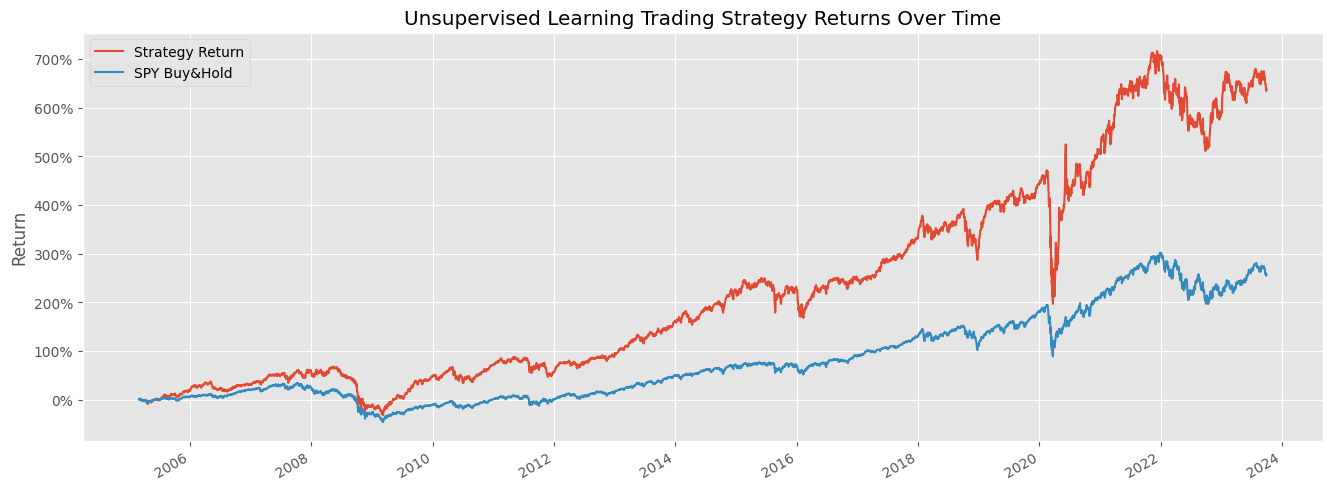

In [90]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()